[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Track Objects with DeepSORT Tracker

DeepSORT extends the original SORT algorithm by integrating appearance information through a deep association metric. While maintaining the core Kalman filtering and Hungarian algorithm components from SORT, DeepSORT adds a convolutional neural network (CNN) trained on large-scale person re-identification datasets to extract appearance features from detected objects. This integration allows the tracker to maintain object identities through longer periods of occlusion, effectively reducing identity switches compared to the original SORT. DeepSORT operates with a dual-metric approach, combining motion information (Mahalanobis distance) with appearance similarity (cosine distance in feature space) to improve data association decisions. It also introduces a matching cascade that prioritizes recently seen tracks, enhancing robustness during occlusions. Most of the computational complexity is offloaded to an offline pre-training stage, allowing the online tracking component to run efficiently at approximately 20Hz, making it suitable for real-time applications while achieving competitive tracking performance with significantly improved identity preservation.


## Environment setup

### Configure API keys

To generate DeepSORT features with TIMM, you need to provide your HuggingFace API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jan 15 11:51:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [2]:
!pip install -q inference-gpu
!pip install -q trackers[deepsort]
!pip install -q supervision==0.27.0rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 90.

In [3]:
!pip list | grep supervision
!pip list | grep trackers

supervision                              0.27.0rc1
trackers                                 2.0.1


### Download example data

In [4]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-1.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-2.mp4

## Track objects

### Initiate detector and tracker

In [5]:
from inference import get_model
from trackers import DeepSORTFeatureExtractor, DeepSORTTracker

model = get_model("rfdetr-medium")

feature_extractor = DeepSORTFeatureExtractor.from_timm(
    model_name="mobilenetv4_conv_small.e1200_r224_in1k")

tracker = DeepSORTTracker(feature_extractor=feature_extractor)

ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support YoloWorld model. Use pip install 'inference[yolo-world]' to install missing requirements.To suppress this warning, set CORE_MODEL

Resolved model_id: coco/40, dataset_id: coco, version_id: 40


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.safetensors:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

### Configure annotators

In [6]:
import supervision as sv

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

box_annotator = sv.BoxAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK)

trace_annotator = sv.TraceAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2,
    trace_length=75)

label_annotator = sv.LabelAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)

### Run detection + tracking

In [7]:
CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

SOURCE_VIDEO_PATH = "/content/bikes-1280x720-1.mp4"
TARGET_VIDEO_PATH = "/content/bikes-1280x720-1-result.mp4"

frame_samples = []

def callback(frame, i):
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)
    detections = tracker.update(detections, frame=frame)

    annotated_image = frame.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = trace_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, detections.tracker_id)

    if i % 30 == 0 and i != 0:
        frame_samples.append(annotated_image)

    return annotated_image

tracker.reset()

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True,
)

Processing video:   0%|          | 0/388 [00:00<?, ?it/s]

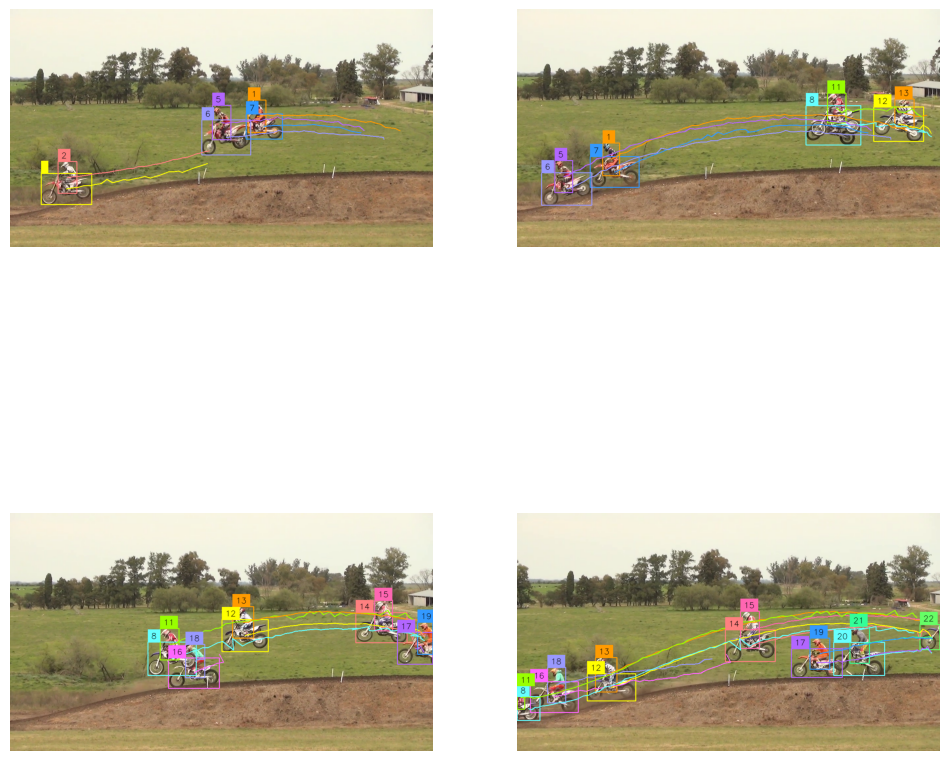

In [8]:
sv.plot_images_grid(images=frame_samples[:4], grid_size=(2, 2))

Just combined DeepSORT with RF-DETR detector from `inference` — nice work! `trackers` makes it easy to mix and match top-performing multi-object tracking algorithms with your favorite detection backends, including `inference`, `ultralytics`, and `transformers`.

Ready to go deeper. Explore more tracking algorithms and integrations in the trackers [Documentation](https://roboflow.github.io/trackers/develop/) or dive into the code on [GitHub](https://github.com/roboflow/trackers). Got feedback or ideas, open an issue on [GitHub Issues](https://github.com/roboflow/trackers/issues).